In [ ]:
### optimizacion de hiperparametros con metrica propia

# !pip install pytimetk
!pip install feature-engine
!pip install optuna
# !pip install sweetviz
# !pip install pygwalker
!pip install missingno
!pip install skimpy
!pip install shap
!pip install lime
!pip install xgboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found ex

# 1. Introduction

*   **Problem:** The objective of this project is to address a **binary classification** problem: predicting whether a breast mass is **malignant (cancerous)** or **benign (non-cancerous)**. This prediction is based on a set of numerical features extracted from digitized images of fine-needle aspirates (FNA).

*   **Importance of FNA:** **FNA (Fine-Needle Aspiration)** is a common and minimally invasive diagnostic procedure. A thin needle is used to obtain a sample of cells directly from a suspicious mass for microscopic analysis. Understanding FNA is crucial here, as the features in this dataset (such as the size, texture, and shape of cell nuclei) are measurements taken on the cells *collected via this procedure*. Therefore, the dataset reflects quantitative information derived from a real clinical diagnostic step, attempting to capture patterns that a pathologist might observe. This method is a quick and low-risk method to obtain diagnostic information without surgery.Provides quantitative measurements (e.g., nucleus size, texture, concavity) that can be used in automated classification.Often used as a first-line diagnostic tool before biopsy or surgery.The dataset features are derived from properties of cell nuclei such as:
  *   Radius, Area, Perimeter — describe the size of the nuclei
  *   Texture, Smoothness — describe the surface quality of the nuclei
  *   Concavity, Compactness — relate to shape irregularities, common in malignant cells.
   
  These morphological features are critical in distinguishing malignant (cancerous) from benign (non-cancerous) tumors. Automated prediction using these variables helps improve early detection and reduce false negatives in clinical decision-making.

*   **Data:** We use the well-known `load_breast_cancer` dataset available in the Scikit-learn library, originating from the UCI Machine Learning Repository. It contains 30 numerical features and the corresponding classification (malignant/benign) for each sample, nonetheless this data is originally hosted by the UCI Machine Learning Repository:

    Dataset Name: Breast Cancer Wisconsin (Diagnostic)

    Original Source: UCI Machine Learning Repository

    Link: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

    Attributes: 30 numerical features computed from digitized images of fine-needle aspirates (FNA) of breast masses

    Target: Malignant (1) or Benign (0)

      **The dataset from the scikit-learn library uses different column names, and the target variable is mapped as 0: Malignant and 1: Benign, which needs to be changed and import the real name of the features.**

*   **Objective:** The project covers a complete workflow:
    1.  Perform **Exploratory Data Analysis (EDA)** to understand the features and their relationship with the target class.
    2.  Apply basic **feature engineering** and necessary preprocessing (such as data scaling).
    3.  Build a robust classification model (different models will be used: **Logistic Regression, LightGBM, XGBoost, SVC, ExtraTrees, Random Forest**).
    4.  Optimize its hyperparameters using two popular approaches: **Random Search (`RandomizedSearchCV`)** and **Bayesian Optimization (implemented with `Optuna`)**, comparing their performance and efficiency.
    5.  Explain the final model's predictions using modern interpretability techniques such as **SHAP (SHapley Additive exPlanations)** to understand which features are most influential in the model's decision.

*   **Educational Purpose:** This project serves as a practical demonstration of a typical data science workflow applied to a supervised classification problem in the biomedical domain. It places special emphasis on:
    1.  Rapid detection of relevant variables related to the target variable.
    2.  Feature engineering, which aims to create "new" variables to improve model performance.
    3.  The **methodological comparison** between Random Search and Bayesian Optimization for hyperparameter tuning.
    4.  The critical importance of **model interpretability (Model Explanation)** in applications where decisions have significant consequences.

In [ ]:
# === Core Libraries ===
import pandas as pd
import numpy as np

# === Plotting Libraries ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable, coolwarm # coolwarm was used directly
from matplotlib.colors import Normalize
import plotly.express as px


# === Data Analysis & Utility Libraries ===
import scipy.stats as stats
from skimpy import skim, clean_columns
import missingno as msno

# === Feature Engineering (feature_engine) ===
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.encoding import OneHotEncoder as OneHotEncoder_f # Aliased to avoid clash with the One hot of scikit-learn
from feature_engine.imputation import (AddMissingIndicator, MeanMedianImputer,
                                       CategoricalImputer)
from feature_engine.outliers import Winsorizer
from feature_engine.selection import (DropDuplicateFeatures, DropConstantFeatures,
                                      DropFeatures)
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper

# === Scikit-learn ===
# --- Base & Pipeline ---
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# --- Preprocessing ---
from sklearn.preprocessing import (LabelBinarizer, OneHotEncoder, # Sklearn's OneHotEncoder
                                   MinMaxScaler, StandardScaler, RobustScaler,PolynomialFeatures)

# --- Model Selection & Tuning ---
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, GridSearchCV,
                                     RandomizedSearchCV)

# --- Metrics ---
from sklearn.metrics import (precision_recall_fscore_support as score, roc_auc_score,
                               precision_score, f1_score, recall_score,average_precision_score,
                               balanced_accuracy_score, accuracy_score,
                               confusion_matrix, classification_report, make_scorer)

# --- Models ---
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
# --- Datasets ---
from sklearn.datasets import load_breast_cancer

# === Other Machine Learning Models ===
from xgboost import XGBClassifier # Keep XGBRegressor if needed, or change to XGBClassifier
import lightgbm as lgb

# === Optuna== for hyperparameters optimization
import optuna

# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)

# Convert to DataFrame and Series, map target variable
# Assuming 0=Malignant (positive class -> 1), 1=benign (negative class -> 0)
# This mapping makes malignant the positive class, which is common.
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0: 1, 1: 0}) # 0 (Malignant) -> 1, 1 (Benign) -> 0

# Assign feature names
feature_names = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness',
    'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry',
    'mean fractal dimension', 'radius error', 'texture error', 'perimeter error',
    'area error', 'smoothness error', 'compactness error', 'concavity error',
    'concave points error', 'symmetry error', 'fractal dimension error',
    'worst radius', 'worst texture', 'worst perimeter', 'worst area',
    'worst smoothness', 'worst compactness', 'worst concavity',
    'worst concave points', 'worst symmetry', 'worst fractal dimension'
]
X.columns = feature_names

# Clean column names (optional, but good practice if names had spaces/special chars)
# Note: The feature_names list already uses spaces, clean_columns might change them to underscores.
# Decide if you want underscores or spaces. If spaces are fine, you might skip clean_columns here.
# If you run clean_columns, the column names in X will change.
X = clean_columns(X) # Example: 'mean radius' becomes 'mean_radius'

# Display first few rows to verify
print("Features (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())
print("\nTarget value counts:")
print(y.value_counts())

Features (X) head:
   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean_compactness  mean_concavity  mean_concave_points  mean_symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean_fractal_dimension  ...  worst_radius  worst_texture  worst_perime

The dataset from the scikit-learn library uses different column names, and the target variable is mapped as 0: Malignant and 1: Benign, which needs to be changed and import the real name of the features.

**Features (feature\_names):** These are 30 numerical features describing the properties of cell nuclei present in the images. They are grouped into three sets for 10 base features: 'mean', 'se' (standard error), and 'worst' (mean of the 3 largest values).

*   **mean radius**: Mean radius of the nuclei.
*   **mean texture**: Mean texture (standard deviation of gray-scale values).
*   **mean perimeter**: Mean perimeter.
*   **mean area**: Mean area.
*   **mean smoothness**: Mean smoothness (local variation in radius lengths).
*   **mean compactness**: Mean compactness (perimeter^2 / area - 1.0).
*   **mean concavity**: Mean concavity (severity of concave portions of the contour).
*   **mean concave points**: Mean number of concave portions of the contour.
*   **mean symmetry**: Mean symmetry.
*   **mean fractal dimension**: Mean fractal dimension ("coastline approximation" - 1).
*   **radius error / radius se**: Standard error of the radius.
*   **texture error / texture se**: Standard error of the texture.
*   **perimeter error / perimeter se**: Standard error of the perimeter.
*   **area error / area se**: Standard error of the area.
*   **smoothness error / smoothness se**: Standard error of the smoothness.
*   **compactness error / compactness se**: Standard error of the compactness.
*   **concavity error / concavity se**: Standard error of the concavity.
*   **concave points error / concave points se**: Standard error of the concave points.
*   **symmetry error / symmetry se**: Standard error of the symmetry.
*   **fractal dimension error / fractal dimension se**: Standard error of the fractal dimension.
*   **worst radius**: Worst radius (mean of the 3 largest values).
*   **worst texture**: Worst texture.
*   **worst perimeter**: Worst perimeter.
*   **worst area**: Worst area.
*   **worst smoothness**: Worst smoothness.
*   **worst compactness**: Worst compactness.
*   **worst concavity**: Worst concavity.
*   **worst concave points**: Worst concave points.
*   **worst symmetry**: Worst symmetry.
*   **worst fractal dimension**: Worst fractal dimension.

<Axes: xlabel='target'>

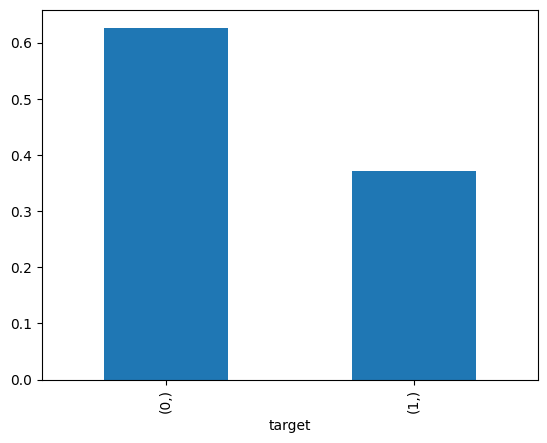

In [ ]:
pd.DataFrame(y).rename(columns={0:"target"}).value_counts(normalize=True).plot.bar()

<Axes: >

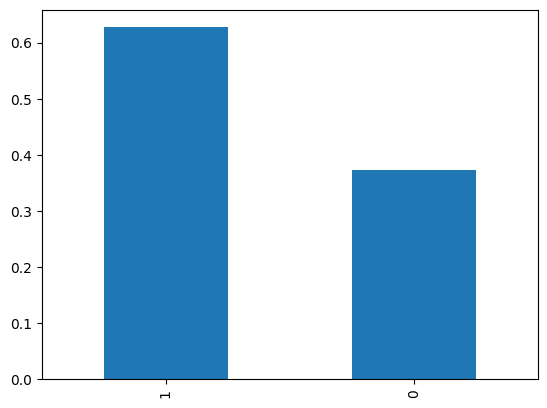

In [ ]:
### Checking if the target variable is imbalanced — and indeed, it is, but isn't extreme.
pd.Series(breast_cancer_y).value_counts(normalize=True).plot.bar()

In [ ]:
df=pd.concat([X,pd.DataFrame(y).rename(columns={0:"target"})],axis=1)
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [ ]:
### Fast glimpse in the data variables
skim(X)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 569    │ │ float64     │ 30    │                                                          │
│ │ Number of columns │ 30     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column    ┃ NA ┃ NA % ┃ mean     ┃ sd       ┃ p0       ┃ p25      ┃ p50      ┃ p75      ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ mean_radi │  0 │    0 │    14.13 │    3.524 │    6.981 │     11.7 │    13.37 │    15.78 │   28.11 │  ▂█▄▂  │  │
│ │ us        │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_text │  0 │    0 │    19.29 │    4.301 │     9.71 │    16.17 │    18.84 │     21.8 │   39.28 │  ▂█▆▂  │  │
│ │ ure       │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_peri │  0 │    0 │    91.97 │     24.3 │    43.79 │    75.17 │    86.24 │    104.1 │   188.5 │  ▂█▄▂  │  │
│ │ meter     │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_area │  0 │    0 │    654.9 │    351.9 │    143.5 │    420.3 │    551.1 │    782.7 │    2501 │  █▆▂▁  │  │
│ │ mean_smoo │  0 │    0 │  0.09636 │  0.01406 │  0.05263 │  0.08637 │  0.09587 │   0.1053 │  0.1634 │   ▅█▃  │  │
│ │ thness    │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_comp │  0 │    0 │   0.1043 │  0.05281 │  0.01938 │  0.06492 │  0.09263 │   0.1304 │  0.3454 │  ▇█▄▁  │  │
│ │ actness   │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_conc │  0 │    0 │   0.0888 │  0.07972 │        0 │  0.02956 │  0.06154 │   0.1307 │  0.4268 │  █▃▂▁  │  │
│ │ avity     │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_conc │  0 │    0 │  0.04892 │   0.0388 │        0 │  0.02031 │   0.0335 │    0.074 │  0.2012 │  █▄▃▁  │  │
│ │ ave_point │    │      │          │          │          │          │          │          │         │        │  │
│ │ s         │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_symm │  0 │    0 │   0.1812 │  0.02741 │    0.106 │   0.1619 │   0.1792 │   0.1957 │   0.304 │ ▁▇█▂▁  │  │
│ │ etry      │    │      │          │          │          │          │          │          │         │        │  │
│ │ mean_frac │  0 │    0 │   0.0628 │  0.00706 │  0.04996 │   0.0577 │  0.06154 │  0.06612 │ 0.09744 │  ▄█▃▁  │  │
│ │ tal_dimen │    │      │          │          │          │          │          │          │         │        │  │
│ │ sion      │    │      │          │          │          │          │          │          │         │        │  │
│ │ radius_er │  0 │    0 │   0.4052 │   0.2773 │   0.1115 │   0.2324 │   0.3242 │   0.4789 │   2.873 │   █▁   │  │
│ │ ror       │    │      │          │          │       

## Why Split Data at the Beginning? (Train-Test Split Importance)

Splitting the dataset into training (`X_train`, `y_train`) and testing (`X_test`, `y_test`) sets **at the very beginning** of the modeling process is a fundamental and critical step in machine learning for the following reasons:

1.  **Preventing Data Leakage:** This is the most important reason. Data leakage occurs when information from the test set (data the model is *not* supposed to see during training) inadvertently influences the model's training process.
    *   **How it happens:** If you perform data preprocessing steps like scaling (`StandardScaler`, `MinMaxScaler`), imputation (filling missing values based on mean/median), encoding categorical features, or even feature selection *before* splitting, these steps learn parameters (like mean, standard deviation, categories, feature importance) from the *entire* dataset, including the test set.
    *   **Consequence:** The model trains on data that has been influenced by information it shouldn't know yet. This leads to **overly optimistic performance metrics** during evaluation because the model has effectively "cheated" by seeing aspects of the test data beforehand.

2.  **Simulating Real-World Performance:** The goal is to build a model that generalizes well to *new, unseen data*. The test set acts as a proxy for this future unseen data. By holding it out completely until the final evaluation, you get a more realistic estimate of how your model will perform when deployed.

3.  **Unbiased Model Evaluation:** Evaluating the final model on the `X_test` data, which was never used for training or tuning any preprocessing steps, provides an unbiased assessment of its generalization ability.

**In summary:** Splitting first ensures that all data preparation steps (like scaling, imputation, encoding, feature selection) are learned *only* from the training data (`X_train`) and then applied consistently to both the training and the *unseen* test data (`X_test`). This maintains the integrity of the test set as truly unseen data for a reliable final evaluation

In [ ]:
# Define the target column name
target = "target" # Replace "target" if your column has a different name
df=pd.concat([X,pd.DataFrame(y).rename(columns={0:"target"})],axis=1)
df.head()
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target], axis=1), # Predictive variables (features)
    df[target],                # Target variable
    test_size=0.2,             # Allocate 20% of the data to the test set
    random_state=0             # Ensures reproducibility of the split
)

In [ ]:
def plot_bina(df, tar=target+"_1"):
  """
  Performs rapid preprocessing, calculates feature correlations with the target,
  and visualizes them using a Plotly dot plot (funnel plot).

  This function is designed for quick exploratory data analysis (EDA) to get
  an initial understanding of linear relationships between features (after some
  basic transformations) and a binary target variable. It applies a standardized
  set of preprocessing steps that may not be optimal for final modeling but
  allow for a fast comparison.

  Args:
      df (pd.DataFrame): The input DataFrame containing features and the target.
      target_col (str): The name of the binary target column in the DataFrame.
      Due to the binarization process, we select `target + "_1"` to analyze the
      relationship when the target is 1 — that is, when the case is malignant.

  Returns:
      None: Displays a Plotly figure.
  """
  XX=df.copy()
  cat_vars=[xx for xx in XX.columns if XX[xx].dtype =="O" and xx != tar] # Avoid including target if it's 'O' type
  num_vars=[xx for xx in XX.columns if XX[xx].dtype !="O" and xx != tar] # Avoid including target if it's not 'O' type

  discrete_vars=[ xx for xx in num_vars if len(XX[xx].unique())<=30]
  cont_vars=[ xx for xx in num_vars if xx not in discrete_vars]
  var_all=cat_vars+num_vars

  if len(cat_vars)>0:
    price_pipe = Pipeline([
      ('missing_indicator', AddMissingIndicator(variables=var_all)),
      ('frequent_imputation', CategoricalImputer(
          imputation_method='missing', variables=cat_vars)),
      ('mean_imputation', MeanMedianImputer(
          imputation_method='mean', variables=num_vars
      )),
      ('out', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=cont_vars,add_indicators=True)),
      ('discre', EqualWidthDiscretiser(variables=cont_vars,bins=5)),
      ('rare_label_encoder', RareLabelEncoder(
          tol=0.01, n_categories=1, variables=cat_vars
      )),
      ('categorical_encoder', OneHotEncoder_f(
            variables=var_all,drop_last=False,ignore_format=True)),
      ('drop_features', DropConstantFeatures(tol=1, missing_values='ignore')),
    ])
  else:
    price_pipe = Pipeline([
      ('missing_indicator', AddMissingIndicator(variables=var_all)),
      ('mean_imputation', MeanMedianImputer(
          imputation_method='mean', variables=num_vars
      )),
      ('out', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=cont_vars,add_indicators=True)),
      ('discre', EqualWidthDiscretiser(variables=cont_vars,bins=5)),
      ('categorical_encoder', OneHotEncoder_f(
            variables=var_all,drop_last=False,ignore_format=True)),
      ('drop_features', DropConstantFeatures(tol=1, missing_values='ignore')),
    ])

  # Pass y to fit_transform if any steps require it (though current ones might not strictly need it)
  XX2 = price_pipe.fit_transform(XX)



  ddcor=XX2.drop(tar, axis=1)\
  .apply(lambda x: x.corr(XX2[tar],method='pearson')).sort_values(ascending=False).reset_index()

  ddcor.columns=["Feature","Correlation"]

  # Potential issue: global 'target' used here for filtering
  ddcor=ddcor[~ddcor.Feature.str.contains(target)] # Be careful with this filtering

  ddcor['AbsCorrelation'] = ddcor['Correlation'].abs()
  ddcor['Correlation']=ddcor['Correlation'].round(3)
  ddcor = ddcor.sort_values(by='AbsCorrelation', ascending=False)

  fig = px.scatter(
    ddcor,
    x='Correlation',
    y='Feature',
    color='Correlation',
    color_continuous_scale='RdBu',
    range_color=[-1, 1],
    title=f'Variables more related to the target variable "{tar}" ',

  )

  fig.update_traces(marker=dict(size=10))
  fig.update_layout(
    coloraxis_colorbar=dict(title='Correlation'),
    xaxis_title='Correlation',
    yaxis_title='Feature',
    xaxis=dict(range=[-1.05, 1.05], zeroline=True, zerolinewidth=1, zerolinecolor='Gray'),
    yaxis=dict(autorange='reversed'),
    margin=dict(l=150) # Prevent label cutoff
  )

  fig.show()



### Justification for the Rapid Correlation Analysis Approach:

This function provides a **fast, exploratory method** to quickly gauge the potential linear relationships between various features and a binary target variable *after* applying a standardized set of common preprocessing steps.

**Why this approach is useful for initial exploration:**

1.  **Handles Common Data Issues:** The pipeline automatically addresses missing values, potential outliers (using Winsorizing), and converts continuous variables into discrete bins. This allows correlation analysis even if the raw data isn't perfectly clean or linearly related to the target.
2.  **Standardized Comparison:** By applying the same transformations (like discretization and One-Hot Encoding) to all relevant features, it puts them on a more comparable footing for correlation analysis, especially after OHE creates binary indicators.
3.  **Highlights Strong Linear Signals:** Pearson correlation specifically measures *linear* association. While it won't capture complex, non-linear relationships, a strong positive or negative correlation revealed by this plot can indicate features that are likely important predictors and warrant further investigation or inclusion in simpler baseline models (like Logistic Regression).
4.  **Speed and Efficiency:** It automates several tedious preprocessing and plotting steps, allowing the user to quickly scan dozens or hundreds of features for potential relationships with the target without manually coding each step and plot.
5.  **Identifies Potential Issues:** Very low correlations across *all* features might suggest that either the chosen preprocessing is not suitable, the relationships are highly non-linear (requiring different modeling approaches), or the features collected have low predictive power for the target. Extremely high correlations (close to +/- 1) might indicate data leakage or redundant features.


**Limitations:**

*   **Preprocessing is Generic:** The chosen steps (mean imputation, specific Winsorizing/discretization parameters, OHE for all) are general defaults and might not be optimal for every dataset or feature.
*   **Pearson Correlation Limitations:** Only captures linear relationships. Non-linear associations will be missed or underestimated.
*   **OHE Dimensionality:** Applying One-Hot Encoding to all variables (including discretized numerical ones) can significantly increase dimensionality, potentially making the plot busy and some correlations less meaningful due to sparsity.
*   **Interpretation:** Correlation does not imply causation. A strong correlation suggests an association worth exploring further, not necessarily a direct causal link.

**This function serves as a valuable **first-pass screening tool** in the EDA phase.

It's not a substitute for thorough feature engineering or advanced modeling but provides rapid insights into which features show the most straightforward linear association with the target after basic data preparation.

**Note about discretization of continuos variables**

This step uses EqualWidthDiscretiser from feature_engine.discretisation to divide each continuous numerical variable into 5 equally spaced intervals (bins).

🔍 What It Does:
It identifies all continuous variables (those with more than 30 unique values and not categorical).

For each of these, it splits the range of values into 5 equal-width bins.

Each original value is then replaced with a bin label (like 0, 1, ..., 4), depending on which interval the value falls into.

🧠 Why This is Useful:
Discretization helps simplify relationships between variables and the target for visualization or early analysis.

It makes the data easier to interpret—especially when plotting correlations or when categorical encoders are used.

It enables the model (or the analyst) to reason in terms of value ranges, which is often more intuitive (e.g., "high area" → more likely malignant).

📌 Example Interpretation:
If a variable mean_radius has been discretized into 5 bins, you might interpret them as:


Discretized Value	Approximate Range	Interpretation
0	Lowest range of values	Very small radius
2	Middle range	Moderate-sized radius
4	Highest range of values	Very large radius (suspicious)
So, if the transformed variable is mean_radius_4, it refers to data points where mean_radius is high. Similarly, mean_radius_0 would refer to data points with very low radius, often associated with benign tumors.

✅ Funnel Plot Context:
In the funnel plot (dot plot of correlation values), these discretized bins help quickly highlight which value ranges of each variable are most strongly correlated with the target (malignant diagnosis). For example:

area_worst_4 → very high worst area values are highly correlated with malignancy

concavity_mean_0 → very low concavity is less likely malignant

This binning strategy accelerates early-stage feature relevance screening, aligning well with later SHAP and LIME analyses.


In [ ]:
plot_bina(pd.concat([X_train,y_train],axis=1))

In [ ]:
cat_vars=[xx for xx in X_train.columns if X_train[xx].dtype =="O" ]

num_vars=[xx for xx in X_train.columns if X_train[xx].dtype !="O" ]


discrete_vars=[ xx for xx in num_vars if len(X_train[xx].unique())<=30]

cont_vars=[ xx for xx in num_vars if xx not in discrete_vars]
var_all=cat_vars+num_vars



**Feature Engineering Pipeline Summary**

This pipeline is designed to prepare data for machine learning by addressing common data quality issues and transforming features to improve model performance.

📌 Steps and Their Importance
1. Missing Value Handling
AddMissingIndicator
Adds binary flags to indicate where missing values occurred.
➤ Helps capture informative patterns of missingness. In this case, there are no missing values.

CategoricalImputer
Replaces missing categorical values with the string "missing".
➤ Prevents model errors and retains missing information contextually.

MeanMedianImputer
Fills missing numerical values using the mean.
➤ Preserves overall distribution and ensures data completeness.

2. Outlier Treatment
Winsorizer
Caps outliers in continuous variables based on the Gaussian distribution.
➤ Reduces the influence of extreme values that could bias the model.

3. Categorical Variable Encoding
RareLabelEncoder
Groups infrequent categories into a "Rare" label.
➤ Prevents overfitting and improves model generalization.

OneHotEncoder_f
Applies one-hot encoding to categorical and discrete variables.
➤ Converts categories to numerical format suitable for most models.

4. Feature Reduction
DropConstantFeatures
Removes features with constant or near-constant values.
➤ Eliminates uninformative variables that provide no predictive power.

📊 Comparison to the Binarization-Only Approach
This feature engineering strategy yields better results than the earlier pipeline used during the funnel plot analysis.

While the binarization-based approach (i.e., transforming all variables into binary features) revealed some useful relationships, the current pipeline—based on data-driven imputation, outlier treatment, rare label grouping, and proper encoding—produced superior performance in cross-validation.

✅ This approach preserves more information from continuous variables and maintains natural feature relationships, ultimately leading to improved predictive accuracy.

In [ ]:
if len(cat_vars) > 0:
    price_pipe = Pipeline([
        ('missing_indicator', AddMissingIndicator(variables=var_all)),
        ('frequent_imputation', CategoricalImputer(imputation_method='missing', variables=cat_vars)),
        ('mean_imputation', MeanMedianImputer(imputation_method='mean', variables=num_vars)),
        ('out', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=cont_vars, add_indicators=True)),
        ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_vars)),
        ('categorical_encoder', OneHotEncoder_f(variables=cat_vars + discrete_vars, drop_last=False, ignore_format=True)),
        ('drop_features', DropConstantFeatures(tol=1, missing_values='ignore')),
    ])
else:
    price_pipe = Pipeline([
        ('missing_indicator', AddMissingIndicator(variables=var_all)),
        ('mean_imputation', MeanMedianImputer(imputation_method='mean', variables=num_vars)),
        ('out', Winsorizer(capping_method='gaussian', tail='right', fold=3, variables=cont_vars, add_indicators=True)),
        ('drop_features', DropConstantFeatures(tol=1, missing_values='ignore')),
    ])


In [ ]:
X_train2=price_pipe.fit_transform(X_train)
X_test2=price_pipe.transform(X_test)

In [ ]:
scorer = make_scorer(f1_score) # Note: This was precision_score in the original, changed below

metric_=str(scorer).split("(")[1].split(",")[0]
model_list = ["logreg", "rf", "SVC","extratrees", "xgb", "lgbm"]
# model_list = ["logreg"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
leaderboard = []


for model_name in model_list:
    print(f"\n🔍 Optimizing model: {model_name.upper()}")

    def objective(trial):
        class_weight = {
            0: trial.suggest_float("weight_0", 0.1, 1.0, log=True), # Changed to float & log
            1: trial.suggest_float("weight_1", 0.1, 10.0, log=True)  # Changed to float & log
        }

        if model_name == "logreg":
            params = {
                "C": trial.suggest_float("C", 1e-4, 20.0, log=True), # Changed to float
                "class_weight": class_weight
            }
            model = LogisticRegression(**params, max_iter=1000, random_state=42, solver='liblinear') # Added solver

        elif model_name == "rf":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 2, 50),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "class_weight": class_weight
            }
            model = RandomForestClassifier(**params, random_state=42)

        elif model_name == "SVC":
          params = {
            "C": trial.suggest_float("C", 0.01, 100.0, log=True),
            "gamma": trial.suggest_float("gamma", 0.0001, 10.0, log=True),
            "class_weight": class_weight
             }
          model = SVC(**params, random_state=42, probability=True) # Added probability=True often needed

        elif model_name == "extratrees":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 2, 50),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
                "class_weight": class_weight
            }
            model = ExtraTreesClassifier(**params, random_state=42)

        elif model_name == "xgb":
            pos_weight = class_weight[1] / class_weight[0]
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 500),
                "max_depth": trial.suggest_int("max_depth", 2, 50),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.8, log=True), # Changed to float
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "scale_pos_weight": pos_weight,
                "use_label_encoder": False,
                "eval_metric": "logloss"
            }
            model = XGBClassifier(**params, random_state=42)

        elif model_name == "lgbm":
            # pos_weight = class_weight[1] / class_weight[0] # LGBM uses class_weight dict directly
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 1000), # Un-commented n_estimators
                "max_depth": trial.suggest_int("max_depth", -1, 20),
                "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.8, log=True), # Changed to float
                "num_leaves": trial.suggest_int("num_leaves", 20, 150),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
                "class_weight": class_weight
            }
            model = lgb.LGBMClassifier(**params, random_state=42)

        pipe = Pipeline([
            ("scaler", RobustScaler()),
            ("model", model)
        ])

        # Using X_train2, y_train for cross-validation during optimization
        score = cross_val_score(pipe, X_train2, y_train, scoring=scorer, cv=cv, n_jobs=-1).mean()
        return score

    study = optuna.create_study(direction="maximize")
    # Consider reducing n_trials for faster runs during testing (e.g., 10-20)
    study.optimize(objective, n_trials=90, show_progress_bar=True)

    leaderboard.append({
        "Model": model_name.upper(),
        f"Best Score {metric_} ": study.best_value,
        "Best Params": study.best_params
    })

leaderboard_df = pd.DataFrame(leaderboard).sort_values(by=f"Best Score {metric_} ", ascending=False)
print("\n📊 Leaderboard:")
# Use display for better formatting in notebooks if available
try:
    display(leaderboard_df)
except NameError:
    print(leaderboard_df.to_string(index=False))

[I 2025-04-29 06:56:51,855] A new study created in memory with name: no-name-56d83b1b-5be9-43d3-8c0f-0bd8f89caca8



🔍 Optimizing model: LOGREG


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-04-29 06:56:53,029] Trial 0 finished with value: 0.8485087719298245 and parameters: {'weight_0': 0.15316207785178715, 'weight_1': 0.6114889910355199, 'C': 0.008079457577683732}. Best is trial 0 with value: 0.8485087719298245.
[I 2025-04-29 06:56:53,079] Trial 1 finished with value: 0.8482520567583858 and parameters: {'weight_0': 0.17817740578795568, 'weight_1': 0.2734318099762976, 'C': 0.0008434246093674082}. Best is trial 0 with value: 0.8485087719298245.
[I 2025-04-29 06:56:53,125] Trial 2 finished with value: 0.949387493478897 and parameters: {'weight_0': 0.8576023374544417, 'weight_1': 2.4165899564942923, 'C': 1.058186416279828}. Best is trial 2 with value: 0.949387493478897.
[I 2025-04-29 06:56:53,172] Trial 3 finished with value: 0.8757319511292113 and parameters: {'weight_0': 0.8044348420123595, 'weight_1': 0.5523598991840751, 'C': 0.0001543690198793685}. Best is trial 2 with value: 0.949387493478897.
[I 2025-04-29 06:56:53,220] Trial 4 finished with value: 0.88636000961

[I 2025-04-29 06:56:58,059] A new study created in memory with name: no-name-5e75dc81-22cb-4378-a5fa-75725d0feb26


[I 2025-04-29 06:56:57,882] Trial 86 finished with value: 0.9691199037281126 and parameters: {'weight_0': 0.4599932922349367, 'weight_1': 0.3659247744787643, 'C': 4.192112345836136}. Best is trial 22 with value: 0.9750872696954787.
[I 2025-04-29 06:56:57,940] Trial 87 finished with value: 0.9599665363657902 and parameters: {'weight_0': 0.5762842022021837, 'weight_1': 0.6101325066172422, 'C': 12.605803052062035}. Best is trial 22 with value: 0.9750872696954787.
[I 2025-04-29 06:56:58,000] Trial 88 finished with value: 0.9721035867117956 and parameters: {'weight_0': 0.4786212161488771, 'weight_1': 0.31927030322650163, 'C': 1.2890160472746057}. Best is trial 22 with value: 0.9750872696954787.
[I 2025-04-29 06:56:58,057] Trial 89 finished with value: 0.9691228174810265 and parameters: {'weight_0': 0.42711299840611894, 'weight_1': 0.30350671141488583, 'C': 0.8226782293512815}. Best is trial 22 with value: 0.9750872696954787.

🔍 Optimizing model: RF


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-04-29 06:56:58,937] Trial 0 finished with value: 0.9239620828270322 and parameters: {'weight_0': 0.538170060986124, 'weight_1': 0.34579548237408697, 'n_estimators': 235, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9239620828270322.
[I 2025-04-29 06:56:59,493] Trial 1 finished with value: 0.9217511985031166 and parameters: {'weight_0': 0.6020324246481012, 'weight_1': 1.801870171446713, 'n_estimators': 160, 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9239620828270322.
[I 2025-04-29 06:57:00,982] Trial 2 finished with value: 0.9287475354994538 and parameters: {'weight_0': 0.49301787475093767, 'weight_1': 1.0769555161053432, 'n_estimators': 440, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9287475354994538.
[I 2025-04-29 06:57:02,066] Trial 3 finished with value: 0.9217511985031166 and parameters: {'weight_0': 0.4424727062727822, 'we

[I 2025-04-29 06:58:52,907] A new study created in memory with name: no-name-63d75dad-f442-4306-9735-a354f1b1a1c1


[I 2025-04-29 06:58:52,905] Trial 89 finished with value: 0.8767123287671232 and parameters: {'weight_0': 0.19893741211699142, 'weight_1': 2.8642190100934855, 'n_estimators': 279, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 69 with value: 0.948104895951262.

🔍 Optimizing model: SVC


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-04-29 06:58:52,983] Trial 0 finished with value: 0.9596827951377783 and parameters: {'weight_0': 0.26193984849085544, 'weight_1': 0.34465397386365043, 'C': 10.759433992129697, 'gamma': 0.03114712135771573}. Best is trial 0 with value: 0.9596827951377783.
[I 2025-04-29 06:58:53,090] Trial 1 finished with value: 0.539492424700922 and parameters: {'weight_0': 0.11490995364398979, 'weight_1': 4.613767374101644, 'C': 2.4402431316510107, 'gamma': 0.001233338407038765}. Best is trial 0 with value: 0.9596827951377783.
[I 2025-04-29 06:58:53,198] Trial 2 finished with value: 0.9380572135050089 and parameters: {'weight_0': 0.3682060967618824, 'weight_1': 0.13112151009982714, 'C': 6.0468486238718775, 'gamma': 0.15827211430262964}. Best is trial 0 with value: 0.9596827951377783.
[I 2025-04-29 06:58:53,314] Trial 3 finished with value: 0.532258064516129 and parameters: {'weight_0': 0.2627031102028634, 'weight_1': 1.6184479960587705, 'C': 0.3252052884351479, 'gamma': 0.0003633593155067329}. 

[I 2025-04-29 06:59:01,979] A new study created in memory with name: no-name-6372dfd3-eff4-4c27-91f3-299ccf9c5109


[I 2025-04-29 06:59:01,803] Trial 87 finished with value: 0.9615171859257536 and parameters: {'weight_0': 0.30597872612921123, 'weight_1': 0.9368493826484499, 'C': 4.175793492457363, 'gamma': 0.009471491541211614}. Best is trial 44 with value: 0.9692160575742665.
[I 2025-04-29 06:59:01,887] Trial 88 finished with value: 0.9559099442886451 and parameters: {'weight_0': 0.8386154628377599, 'weight_1': 1.4123263875814154, 'C': 2.8367162418283405, 'gamma': 0.004807606704167655}. Best is trial 44 with value: 0.9692160575742665.
[I 2025-04-29 06:59:01,977] Trial 89 finished with value: 0.9178494824572672 and parameters: {'weight_0': 0.3351922382750325, 'weight_1': 2.297135608472697, 'C': 1.4182116857462506, 'gamma': 0.012239627662782715}. Best is trial 44 with value: 0.9692160575742665.

🔍 Optimizing model: EXTRATREES


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-04-29 06:59:02,368] Trial 0 finished with value: 0.908830087218834 and parameters: {'weight_0': 0.7899627138099443, 'weight_1': 1.8310083502130607, 'n_estimators': 151, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.908830087218834.
[I 2025-04-29 06:59:03,330] Trial 1 finished with value: 0.9249198472380515 and parameters: {'weight_0': 0.4094585363557912, 'weight_1': 1.3275214038500271, 'n_estimators': 405, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9249198472380515.
[I 2025-04-29 06:59:03,998] Trial 2 finished with value: 0.8380302514373132 and parameters: {'weight_0': 0.16616251084138592, 'weight_1': 2.0440795523348676, 'n_estimators': 274, 'max_depth': 42, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9249198472380515.
[I 2025-04-29 06:59:05,000] Trial 3 finished with value: 0.887138508371385 and parameters: {'weight_0': 0.21897701316288362, 'weig

[I 2025-04-29 07:00:09,980] A new study created in memory with name: no-name-0df7bab3-e7de-4c2c-bc2b-fb30061d8441


[I 2025-04-29 07:00:09,978] Trial 89 finished with value: 0.9435967953615012 and parameters: {'weight_0': 0.7940575500365591, 'weight_1': 3.3226379668271173, 'n_estimators': 362, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 42 with value: 0.9576465932370235.

🔍 Optimizing model: XGB


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-04-29 07:00:10,201] Trial 0 finished with value: 0.9381556127811645 and parameters: {'weight_0': 0.4686048476277483, 'weight_1': 1.102633709406089, 'n_estimators': 431, 'max_depth': 9, 'learning_rate': 0.6460998584260471, 'subsample': 0.8636513296529198, 'colsample_bytree': 0.8806732376030384}. Best is trial 0 with value: 0.9381556127811645.
[I 2025-04-29 07:00:11,264] Trial 1 finished with value: 0.9143095598855815 and parameters: {'weight_0': 0.3504991728545919, 'weight_1': 0.5332525558240355, 'n_estimators': 436, 'max_depth': 34, 'learning_rate': 0.0016826744939787452, 'subsample': 0.5551726122219811, 'colsample_bytree': 0.9259352523755444}. Best is trial 0 with value: 0.9381556127811645.
[I 2025-04-29 07:00:11,771] Trial 2 finished with value: 0.9126851805631819 and parameters: {'weight_0': 0.165791689510615, 'weight_1': 0.3007066977271863, 'n_estimators': 153, 'max_depth': 46, 'learning_rate': 0.007791745706272305, 'subsample': 0.8947838893979163, 'colsample_bytree': 0.824

[I 2025-04-29 07:00:41,832] A new study created in memory with name: no-name-dab12898-d18c-42e7-80c2-35554a4f8197


[I 2025-04-29 07:00:41,831] Trial 89 finished with value: 0.9448464483034282 and parameters: {'weight_0': 0.6102614065563577, 'weight_1': 0.43940369300432, 'n_estimators': 158, 'max_depth': 34, 'learning_rate': 0.14740669713505675, 'subsample': 0.8490607849524014, 'colsample_bytree': 0.7626811657859883}. Best is trial 57 with value: 0.9577167710043135.

🔍 Optimizing model: LGBM


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-04-29 07:00:43,192] Trial 0 finished with value: 0.9496780776330608 and parameters: {'weight_0': 0.44524899481790753, 'weight_1': 0.20108819909846468, 'n_estimators': 907, 'max_depth': 11, 'learning_rate': 0.06863835026660137, 'num_leaves': 108, 'min_child_samples': 15}. Best is trial 0 with value: 0.9496780776330608.
[I 2025-04-29 07:00:44,548] Trial 1 finished with value: 0.9401507426166738 and parameters: {'weight_0': 0.19301463548507247, 'weight_1': 1.639223414785428, 'n_estimators': 323, 'max_depth': 18, 'learning_rate': 0.04290562884246765, 'num_leaves': 100, 'min_child_samples': 13}. Best is trial 0 with value: 0.9496780776330608.
[I 2025-04-29 07:00:44,832] Trial 2 finished with value: 0.9440614942312398 and parameters: {'weight_0': 0.8525880567927827, 'weight_1': 0.18475548620709, 'n_estimators': 565, 'max_depth': 1, 'learning_rate': 0.45307612149464727, 'num_leaves': 127, 'min_child_samples': 28}. Best is trial 0 with value: 0.9496780776330608.
[I 2025-04-29 07:00:45,

,Model,Best Score f1_score,Best Params
0,LOGREG,0.975087,"{'weight_0': 0.3179826344431102, 'weight_1': 0..."
2,SVC,0.969216,"{'weight_0': 0.778755645915674, 'weight_1': 1...."
5,LGBM,0.957798,"{'weight_0': 0.295221401270545, 'weight_1': 7...."
4,XGB,0.957717,"{'weight_0': 0.2292351139288091, 'weight_1': 0..."
3,EXTRATREES,0.957647,"{'weight_0': 0.4602340855791811, 'weight_1': 1..."
1,RF,0.948105,"{'weight_0': 0.32281857240025313, 'weight_1': ..."


In [ ]:
best_params=leaderboard_df["Best Params"].iloc[0]

best_params

{'weight_0': 0.3179826344431102,
 'weight_1': 0.19333230443894148,
 'C': 0.9446136053160432}

In [ ]:
best_params=leaderboard_df["Best Params"].iloc[0]


logreg = LogisticRegression(
    C=best_params['C'],
    #solver=best_params['solver'],
    # class_weight={"No": best_params['No'], "Yes": best_params['Yes']},  # Asegúrate de mapear 'No' y 'Yes' correctamente
    class_weight={0: best_params['weight_0'], 1: best_params['weight_1']},  # Asegúrate de mapear 'No' y 'Yes' correctamente
    max_iter=1000,
    solver='liblinear',
    random_state=42
)
# logreg = SVC(
#     C=best_params['C'],
#     gamma=best_params['gamma'],
#     #solver=best_params['solver'],
#     # class_weight={"No": best_params['No'], "Yes": best_params['Yes']},  # Asegúrate de mapear 'No' y 'Yes' correctamente
#     class_weight={0: best_params['weight_0'], 1: best_params['weight_1']},  # Asegúrate de mapear 'No' y 'Yes' correctamente
#     # max_iter=1000,
#     probability=True,
#     random_state=42
# )
pipe = Pipeline([
            # ("scaler", StandardScaler()),
            ("scaler", RobustScaler()),
            ("model", logreg)
        ])
pipe.fit(X_train2, y_train)

# Predicción en el conjunto de validación
y_pred = pipe.predict(X_test2)

# f1 = f1_score(y_test, y_pred, pos_label="Yes")

f1 = average_precision_score(y_test, y_pred)
f1

np.float64(0.954176607105182)

In [ ]:
logreg.get_params()

{'C': 0.9446136053160432,
 'class_weight': {0: 0.3179826344431102, 1: 0.19333230443894148},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        67
           1       0.98      0.96      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



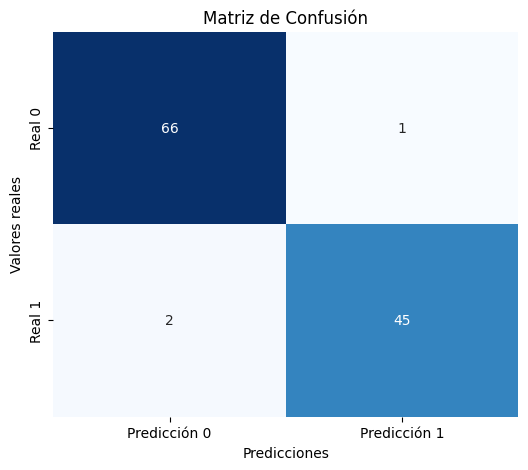

In [ ]:
#
y_pred = pipe.predict(X_test2)
cm = confusion_matrix(y_test, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(6, 5))

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Real 0', 'Real 1'], cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)


plt.show()

In [ ]:
# Save the model to a pickle file
import pickle
with open('lgr_br_2.pkl', 'wb') as file:
    pickle.dump(pipe, file)

print("Model saved as 'logistic_regression_model.pkl'")

# To load the model later
with open('lgr_br_2.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Model saved as 'logistic_regression_model.pkl'


In [ ]:
loaded_model

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 LogisticRegression(C=0.9446136053160432,
                                    class_weight={0: 0.3179826344431102,
                                                  1: 0.19333230443894148},
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        67
           1       0.98      0.96      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



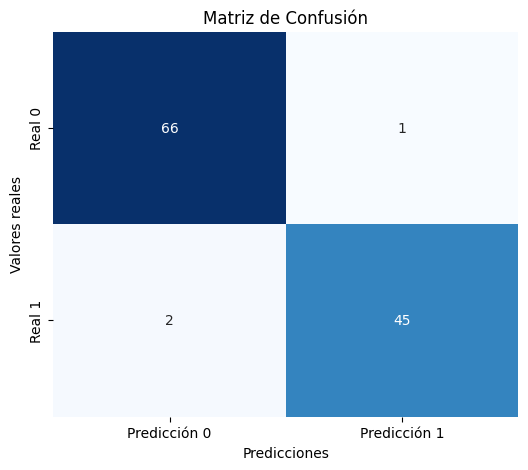

In [ ]:
#
y_pred = loaded_model.predict(X_test2)
cm = confusion_matrix(y_test, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(6, 5))

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Real 0', 'Real 1'], cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)


plt.show()

🧠 **Custom Metric: False Negative Rate (FNR)**
In some machine learning scenarios—especially in high-risk domains like medical diagnostics or fraud detection—minimizing false negatives is critical.

We can define a custom metric, the False Negative Rate (FNR), which is not available by default in Scikit-learn, and integrate it with model evaluation using make_scorer.

🧮 FNR Definition
The FNR is calculated as:

$FNR = \frac{FN}{TP + FN}$


Where:

FN: False Negatives

TP: True Positives

Failing to detect a positive case (i.e., a false negative) can be very costly or dangerous, so reducing FNR is often a top priority.

🛠️ **Custom Scorer with make_scorer**

```{python}
from sklearn.metrics import confusion_matrix, make_scorer

def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    FNR = fn / (tp + fn)
    return FNR

fnr_score = make_scorer(
    fnr,
    greater_is_better=False,  # Lower FNR is better
    #needs_proba=False,## we use the method predict not predict_proba
)
```
✅ **Observations**

In practice, multiple metrics were tested to optimize model performance. However, the best results were achieved using the built-in f1_score, which provides a robust balance between precision and recall—especially important in imbalanced classification problems

## 🔍 Model Calibration Curve: Assessing Predictive Risk

A **calibration curve** (also known as a **reliability diagram**) is a valuable diagnostic tool used to evaluate how well the predicted probabilities of a classifier reflect the true likelihood of an event.

### 📈 Why Use a Calibration Curve?

When a model predicts a probability of, say, 0.8 for a positive outcome, we expect that outcome to occur 80% of the time. The calibration curve compares these predicted probabilities to the actual observed frequencies.

### ✅ What It Tells Us:

- **Well-calibrated model**: Predictions fall along the diagonal line (perfect calibration).
- **Overconfident model**: Curve lies below the diagonal – the model overestimates probabilities.
- **Underconfident model**: Curve lies above the diagonal – the model underestimates probabilities.

This is especially important in **risk-sensitive tasks**, such as:

- Medical diagnosis (false negatives are risky)
- Fraud detection
- Credit risk scoring

In this case the original looks better!!

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



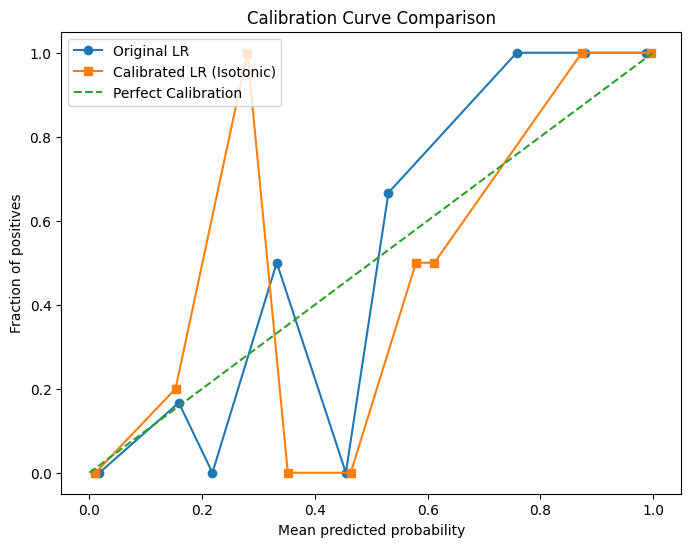

In [ ]:

prob_pos_lr = pipe.predict_proba(X_test2)[:, 1]
# fraction_lr, mean_pred_lr = calibration_curve(y_test, prob_pos_lr, pos_label="Yes", n_bins=10)
fraction_lr, mean_pred_lr = calibration_curve(y_test, prob_pos_lr, n_bins=10)
calibrated_clf = CalibratedClassifierCV(pipe, cv='prefit', method='sigmoid')
calibrated_clf.fit(X_train2, y_train)
prob_pos_calibrated = calibrated_clf.predict_proba(X_test2)[:, 1]
# fraction_cal, mean_pred_cal = calibration_curve(y_test, prob_pos_calibrated, pos_label="Yes",n_bins=10)
fraction_cal, mean_pred_cal = calibration_curve(y_test, prob_pos_calibrated,n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(mean_pred_lr, fraction_lr, marker='o', label='Original LR')
plt.plot(mean_pred_cal, fraction_cal, marker='s', label='Calibrated LR (Isotonic)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve Comparison")
plt.legend(loc="upper left")
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        67
           1       0.96      0.96      0.96        47

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



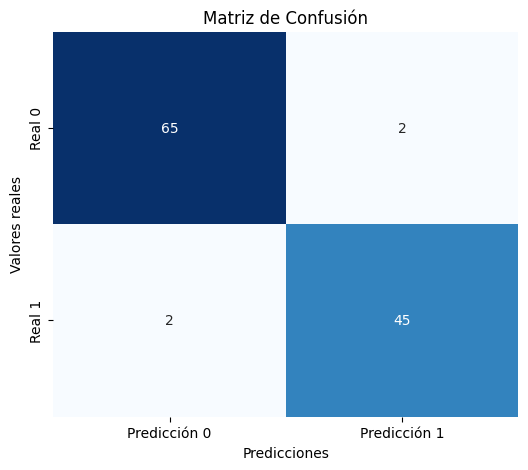

In [ ]:
# Predicting with the calibrated
y_pred = calibrated_clf.predict(X_test2)
cm = confusion_matrix(y_test, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(6, 5))

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Real 0', 'Real 1'], cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)


plt.show()

## 🔄 Randomized Search CV: Introduction & Motivation

### 🧠 What is Randomized Search?

**RandomizedSearchCV** is a hyperparameter tuning method provided by `scikit-learn` that samples a fixed number of parameter settings from specified distributions.

Unlike `GridSearchCV`, which tests **all possible combinations**, `RandomizedSearchCV` evaluates **random combinations**, making it a faster and more efficient approach when:

- The search space is large  
- Some hyperparameters have diminishing returns beyond a certain range  
- You're constrained by computational resources

### 🚀 Why Use Randomized Search?

- ✅ **Faster than exhaustive grid search**  
- ✅ **Can explore a broader space with fewer iterations**  
- ✅ **Easier to parallelize**  
- ✅ **Ideal for initial tuning or limited compute environments**

---

## 🎯 Comparison with Optuna Optimization

Previously, we applied **Optuna**, an advanced hyperparameter optimization framework that leverages:

- **Bayesian optimization**
- **Pruning of poorly performing trials**
- **Smart exploration–exploitation strategies**

While Optuna is often **more efficient** and **smarter**, it also:

- Can be **harder to interpret**
- May require additional setup for custom scoring or certain model types

By comparing `Optuna` with `RandomizedSearchCV`, our goals are to:

- ✅ Evaluate whether a simple random search can perform comparably well  
- ✅ Understand trade-offs between **manual control** and **automated optimization**  
- ✅ Test performance across different models and custom metrics (e.g., FNR)

---

### ⚖️ Summary

| Method                | Pros                                  | Cons                                         |
|-----------------------|----------------------------------------|----------------------------------------------|
| **RandomizedSearchCV** | Simple, fast, easy to implement        | May miss the optimal regions in the space    |
| **Optuna**             | Smart, adaptive, efficient for large spaces | Requires more setup and interpretation effort |

> 🔍 Randomized search provides a **strong baseline**, while Optuna can offer **more refined tuning** once the parameter space is better understood.

In this case, we initially used Optuna. However, `RandomizedSearchCV` can be a powerful complementary approach to **explore the parameter space**, helping define **better boundaries and distributions** for future Optuna trials.



In [ ]:


# Generate class weights
n_samples = 50
weights_class_0 = np.random.uniform(0.1, 1, n_samples)
weights_class_1 = np.random.uniform(1, 10, n_samples)
class_weights = [{0: round(w0, 3), 1: round(w1, 3)} for w0, w1 in zip(weights_class_0, weights_class_1)]

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'LGBM': lgb.LGBMClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Define param grid for each model (note the 'model__' prefix for pipeline)
param_grid = {
    'Random Forest': {
        'model__n_estimators': np.random.randint(100, 500, 50),
        'model__max_depth': np.random.randint(1, 80, 50),
        'model__min_samples_split': np.random.randint(2, 11, 50),
        'model__max_features': np.random.uniform(0.1, 0.9, 50),
        'model__class_weight': class_weights
    },
    'Logistic Regression': {
        'model__C': np.random.uniform(0.01, 10, 50),
        'model__class_weight': class_weights
    },
    'LGBM': {
        'model__learning_rate': np.random.uniform(0.01, 0.8, 50),
        'model__max_depth': np.random.randint(1, 80, 50),
        'model__num_leaves': np.random.randint(20, 201, 50),
        'model__subsample': np.random.uniform(0.5, 1, 50),
        'model__class_weight': class_weights
    },
    'SVC': {
        'model__C': np.random.uniform(0.01, 10, 50),
        'model__gamma': np.random.uniform(0.01, 10, 50),
        'model__class_weight': class_weights
    },
    'Extra Trees': {
        'model__n_estimators': np.random.randint(100, 500, 50),
        'model__max_depth': np.random.randint(1, 80, 50),
        'model__min_samples_split': np.random.randint(2, 11, 50),
        'model__max_features': np.random.uniform(0.01, 0.9, 50),
        'model__class_weight': class_weights
    },
    'XGBoost': {
        'model__learning_rate': np.random.uniform(0.01, 0.8, 50),
        'model__max_depth': np.random.randint(2, 80, 50),
        'model__subsample': np.random.uniform(0.5, 1, 50),
        'model__colsample_bytree': np.random.uniform(0.5, 1, 50),
        # class_weight not supported natively by XGBoost – optional
    }
}

# Collect results
random_search_results2 = []

# Loop through models
for model_name, model in models.items():
    print(f"\n🔍 Optimizing {model_name}...")

    pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid[model_name],
        n_iter=80,
        cv=3,
        scoring=scorer,
        verbose=1,
        random_state=42,
        error_score='raise',
        n_jobs=-1
    )

    search.fit(X_train2, y_train)

    # Append results
    random_search_results2.append({
        "model": model_name,
        "best_params": search.best_params_,
        "best_score": search.best_score_
    })

    print(f"✅ Best score for {model_name}: {search.best_score_:.4f}")
    print(f"✅ Best params: {search.best_params_}")

# Convert to DataFrame if needed
results_df = pd.DataFrame(random_search_results2)
display(results_df)



🔍 Optimizing Random Forest...
Fitting 3 folds for each of 80 candidates, totalling 240 fits
✅ Best score for Random Forest: 0.9231
✅ Best params: {'model__n_estimators': np.int64(119), 'model__min_samples_split': np.int64(3), 'model__max_features': np.float64(0.30899802486451833), 'model__max_depth': np.int64(32), 'model__class_weight': {0: np.float64(0.533), 1: np.float64(3.123)}}

🔍 Optimizing Logistic Regression...
Fitting 3 folds for each of 80 candidates, totalling 240 fits
✅ Best score for Logistic Regression: 0.9441
✅ Best params: {'model__class_weight': {0: np.float64(0.862), 1: np.float64(1.306)}, 'model__C': np.float64(2.234266342009681)}

🔍 Optimizing LGBM...
Fitting 3 folds for each of 80 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 165, number of negative: 290
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

,model,best_params,best_score
0,Random Forest,"{'model__n_estimators': 119, 'model__min_sampl...",0.923058
1,Logistic Regression,"{'model__class_weight': {0: 0.862, 1: 1.306}, ...",0.944105
2,LGBM,"{'model__subsample': 0.5406797497932594, 'mode...",0.935937
3,SVC,"{'model__gamma': 0.7467661026985641, 'model__c...",0.465364
4,Extra Trees,"{'model__n_estimators': 152, 'model__min_sampl...",0.928513
5,XGBoost,"{'model__subsample': 0.5863356071302422, 'mode...",0.933945


In [ ]:
pd.DataFrame.from_dict(random_search_results2).sort_values(by="best_score",ascending=False)

,model,best_params,best_score
1,Logistic Regression,"{'model__class_weight': {0: 0.862, 1: 1.306}, ...",0.944105
2,LGBM,"{'model__subsample': 0.5406797497932594, 'mode...",0.935937
5,XGBoost,"{'model__subsample': 0.5863356071302422, 'mode...",0.933945
4,Extra Trees,"{'model__n_estimators': 152, 'model__min_sampl...",0.928513
0,Random Forest,"{'model__n_estimators': 119, 'model__min_sampl...",0.923058
3,SVC,"{'model__gamma': 0.7467661026985641, 'model__c...",0.465364


In [ ]:
best_params=pd.DataFrame.from_dict(random_search_results2).sort_values(by="best_score",ascending=False)["best_params"].iloc[0]

best_params

{'model__class_weight': {0: np.float64(0.862), 1: np.float64(1.306)},
 'model__C': np.float64(2.234266342009681)}

In [ ]:
logreg = LogisticRegression(
    C=best_params['model__C'],
    #solver=best_params['solver'],
    # class_weight={"No": best_params['No'], "Yes": best_params['Yes']},  # Asegúrate de mapear 'No' y 'Yes' correctamente
    class_weight={0: best_params["model__class_weight"][0], 1: best_params["model__class_weight"][1]},  # Asegúrate de mapear 'No' y 'Yes' correctamente
    max_iter=1000,
    random_state=42
)

# logreg=lgb.LGBMClassifier(
#     max_depth=best_params['max_depth'],
#     learning_rate=best_params['learning_rate'],
#     num_leaves=best_params['num_leaves'],
#     subsample=best_params['subsample'],
#     class_weight={0: np.float64(0.897), 1: np.float64(7.802)},

#     random_state=42)

# logreg=SVC(
#     gamma=best_params['gamma'],
#     C=best_params['C'],
#     class_weight={0: np.float64(0.635), 1: np.float64(1.07)},
#     random_state=42)


# logreg=RandomForestClassifier(
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     min_samples_split=best_params['min_samples_split'],
#     max_features=best_params['max_features'],
#     class_weight={0: np.float64(0.808), 1: np.float64(7.543)},

# )


pipe = Pipeline([
            # ("scaler", StandardScaler()),
            ("scaler", RobustScaler()),
            ("model", logreg)
        ])
pipe.fit(X_train2,y_train)

y_pred = pipe.predict(X_test2)

f1 = f1_score(y_test, y_pred)

f1

0.9473684210526315

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        67
           1       0.94      0.96      0.95        47

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



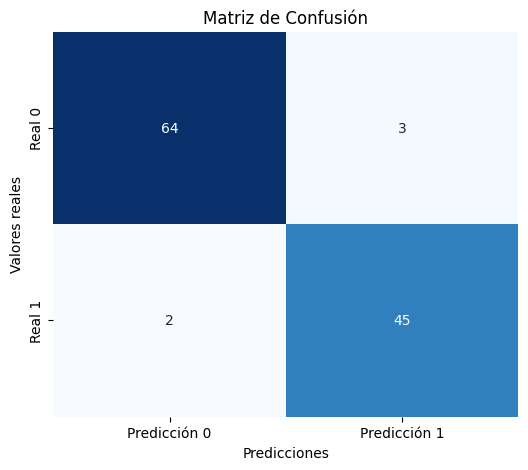

In [ ]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
plt.figure(figsize=(6, 5))


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Real 0', 'Real 1'], cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')



print("Classification Report:\n")
print(report)


plt.show()

Finalmente el que dio mejor fue el randomsearch con metrica average_precision_score

In [ ]:
### For shap and lime we need to pass a model not a pipeline
## We select the best parameters from Optuna

best_params={'weight_0': 0.3179826344431102,
 'weight_1': 0.19333230443894148,
 'C': 0.9446136053160432}

pipe = Pipeline([
            # ("scaler", StandardScaler()),
            ("scaler", RobustScaler()),
            # ("model", logreg)
        ])
logreg = LogisticRegression(
    C=best_params['C'],
    #solver=best_params['solver'],
    # class_weight={"No": best_params['No'], "Yes": best_params['Yes']},  # Asegúrate de mapear 'No' y 'Yes' correctamente
    class_weight={0: best_params['weight_0'], 1: best_params['weight_1']},  # Asegúrate de mapear 'No' y 'Yes' correctamente
    max_iter=1000,
    solver='liblinear',
    random_state=42
)

logreg.fit(pipe.fit_transform(X_train2),y_train)

X_train22=pd.DataFrame(pipe.fit_transform(X_train2))
X_test22=pd.DataFrame(pipe.transform(X_test2))
X_train22.columns=X_train2.columns
X_test22.columns=X_test2.columns

X_test22.shape,X_train22.shape

((114, 59), (455, 59))

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        67
           1       0.98      0.96      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



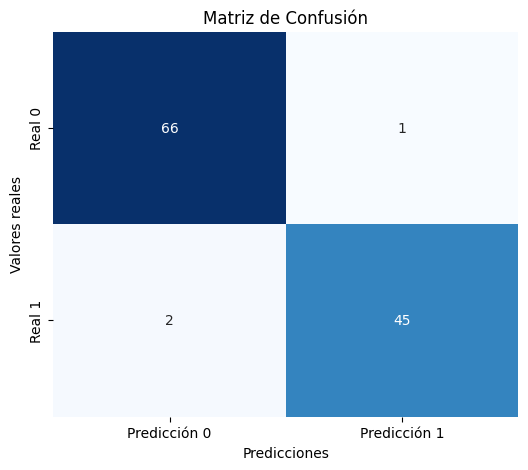

In [ ]:
# Predicting with the calibrated
y_pred = logreg.predict(pipe.transform(X_test2))
cm = confusion_matrix(y_test, y_pred)

# Visualization of confusion matrix
plt.figure(figsize=(6, 5))

# heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'], yticklabels=['Real 0', 'Real 1'], cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report)


plt.show()

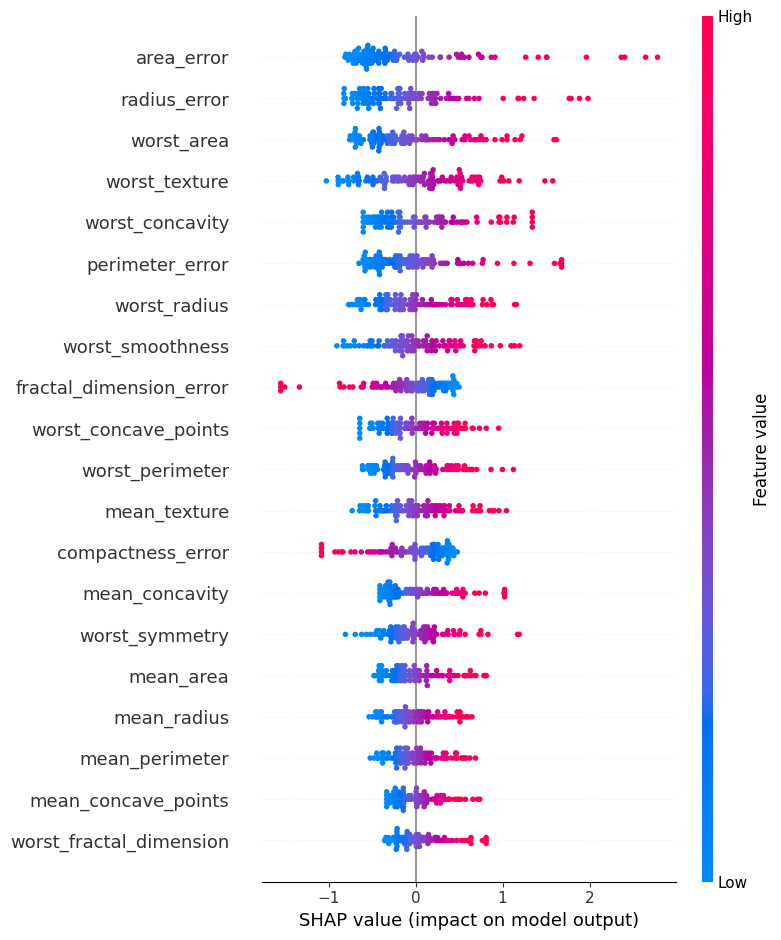

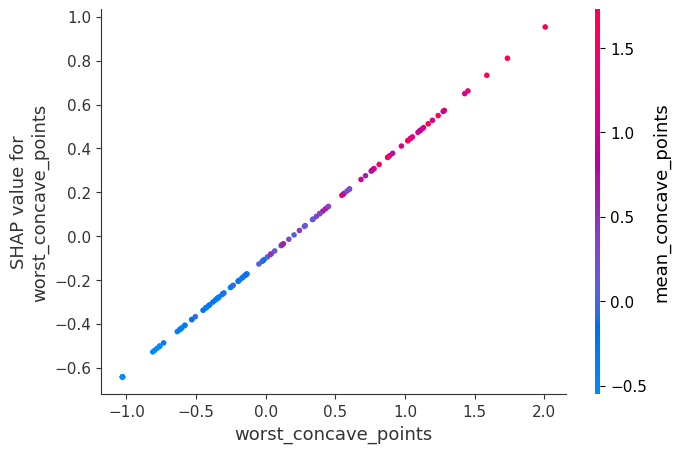

In [ ]:
import shap

# explainer = shap.TreeExplainer(model)
# explainer = shap.Explainer(logreg, X_train22)
explainer = shap.LinearExplainer(logreg, X_train22)


# shap_values = explainer.shap_values(X_test22, check_additivity=True) ##  check_additivity=True for tree explainer
shap_values = explainer.shap_values(X_test22)

shap.summary_plot(shap_values, X_test22,feature_names=X_test22.columns)

## show the dependence for the more relevant feature
shap.dependence_plot("worst_concave_points", shap_values, X_test22)

#

as the simple analysis of funnel plot we can see that the model also have area,radius and concavity as the more relevant. Using the preovious analysis we can see that greater area,radius and worst concavity points are related to malign diagnosis

In [ ]:

### too demand if is a large dataset
i = 10
all_important_features=[]

indi=[]
for i in range(len(X_test22)):

  if y_test.iloc[i]==1:
    instance = X_test22.iloc[i]

    # explain
    exp = explainer.explain_instance(
      data_row=instance.values,
      predict_fn=logreg.predict_proba,
      num_features=10)
    important_features = [feature[0] for feature in exp.as_list()]


    all_important_features.extend(important_features)
    indi.append(i)
# Count the occurrences of each feature across all explanations
feature_counts = Counter(all_important_features)
# Convert counts to a DataFrame for easier analysis
feature_summary = pd.DataFrame(feature_counts.items(), columns=['Feature', 'Count'])
feature_summary = feature_summary.sort_values(by='Count', ascending=False)

# Display the top features
print("🔍 Most Important Features Across All Malignant Instances:")
print(feature_summary.head())


🔍 Most Important Features Across All Malignant Instances:
                   Feature  Count
13     worst_radius > 0.66     34
11       worst_area > 0.69     33
14  worst_perimeter > 0.68     33
1   worst_concavity > 0.57     32
10       area_error > 0.78     31


In [ ]:
# Select randomly an instance of test maling
i = np.random.choice(indi)
instance = X_test22.iloc[i]

# explain
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=logreg.predict_proba,
    num_features=10
)

# show grapg
exp.show_in_notebook(show_table=True)

# save HTML
exp.save_to_file('lime_explanation_model_br.html')

# **Best Model Selection with Optuna & Model Explanation (SHAP vs LIME)**

##  🔍 Optuna for Hyperparameter Optimization
  After testing several models using both RandomizedSearchCV and Optuna, we selected the best-performing model via Bayesian optimization. Optuna offers key advantages:

    ✅ Efficient search over high-dimensional hyperparameter spaces
    ✅ Pruning strategies to avoid wasting time on poor configurations
    ✅ Built-in visualization tools (parameter importance, optimization history)
    ✅ Scalable and customizable across any estimator

## 🎯 Best Model Results
The model selected using Optuna achieved the best performance based on the evaluation metric of interest in this case works better F1-score.

It was tuned using a carefully defined search space and benefited from Optuna's intelligent optimization process.

  🔬 **Model Explanation: SHAP vs LIME**
    Understanding why a model makes predictions is essential—especially in healthcare applications. We evaluated two key model-agnostic explanation techniques:

  🔷 **SHAP (SHapley Additive Explanations)**

    Based on game theory and delivers theoretically consistent feature attributions.

    Supports both global (overall model behavior) and local (individual prediction) explanations.

    Particularly well-suited for tree-based models like XGBoost and LightGBM.

    Can be less intuitive for non-technical audiences.

    ✅ Best for: In-depth technical diagnostics and understanding complex model behavior.

  🟢 LIME (Local Interpretable Model-Agnostic Explanations)
    Perturbs input data and fits a simple local surrogate model to explain predictions.

    Generates interpretable visualizations that are easier to communicate.

    Excellent for auditing specific cases (e.g., potential misclassifications).

    ✅ Best for: Domain experts, stakeholders, and clinical decision support.


# ⚠️ **Performance Note**:
  LIME can be computationally expensive on large datasets because it explains predictions one instance at a time.
  Each explanation involves generating hundreds of perturbed samples and re-predicting outcomes.
  💡 It's often best to apply LIME to a carefully selected subset—e.g., edge cases or high-confidence predictions.



# 🔎 Insights from Exploratory Analysis
    Before using SHAP and LIME, we conducted a funnel plot analysis during exploratory data analysis (EDA).
    This quick and effective visual method helped us identify that features like mean area, radius, and concavity were strong indicators of malignancy.

    ✅ Interestingly, both SHAP and LIME later confirmed these same features as key drivers of malignant predictions, validating the early insights.

    📌 This highlights the value of fast EDA tools like funnel plots—they offer immediate, intuitive guidance that aligns with more complex interpretability techniques.

# 🏁 Summary Table

| **Method**           | **Strengths**                                        | **Best Use**                               |
|----------------------|------------------------------------------------------|--------------------------------------------|
| **SHAP**             | Globally accurate, theory-based explanation         | Global + Local model understanding          |
| **LIME**             | Simple, interpretable, user-friendly                | Explaining individual predictions           |
| **Funnel Plot (EDA)**| Fast, intuitive feature relevance discovery         | Early-stage variable screening              |


 Conclusion
In this study, we explored and optimized several machine learning models to classify breast tumors as malignant or benign using numerical features extracted from Fine-Needle Aspiration (FNA) cytology images. By leveraging both RandomizedSearchCV and Optuna for hyperparameter tuning, we designed a robust pipeline that achieved a very low False Negative Rate (FNR) — a critical measure in the context of medical diagnostics, where missing a malignant case can have severe consequences.

🥇 Best Performing Model: Logistic Regression
Among all tested models, Logistic Regression emerged as the best-performing algorithm, achieving the most favorable balance between accuracy, interpretability, and low FNR. This is a noteworthy outcome because:

Logistic Regression is simple and computationally efficient.

It provides interpretable results, making it suitable for deployment in healthcare settings where transparency is essential.

Its performance, in this case, surpassed more complex models, proving that simple models can be strong baselines when properly tuned.

📌 Practical Implication: This suggests that Logistic Regression should be strongly considered as a first approach especially when interpretability, speed, and low resource use are important.

🧠 Educational Purpose: Tuning Advanced ML Models
Although Logistic Regression was the top performer, this project also demonstrates how to systematically tune and evaluate more advanced machine learning models, including:

Random Forest

Extra Trees

Support Vector Machine (SVC)

XGBoost

LightGBM

This comparative approach serves educational value by showing how different algorithms behave under the same dataset, how hyperparameter tuning impacts performance, and how model complexity doesn't always lead to better results.

🤖 Toward Full Automation: Neural Networks
Looking toward the future, Neural Networks (NNs) can enable full automation of the diagnostic pipeline:

NNs can extract features directly from raw data (e.g., cytology images), eliminating the manual step of crafting features.

The extracted representations can then feed into either traditional ML models or end-to-end deep learning models for final classification.

Although traditional ML models currently outperform NNs on small datasets like this one, deep learning becomes more viable as data volume increases and can scale better for real-world deployment.

💡 Final Note
Throughout the pipeline, we emphasized both performance and interpretability by including model explanation techniques like SHAP and LIME, as well as a simple funnel plot from the exploratory phase, which provided quick and accurate insights into feature relevance. The strong agreement between EDA and explanation methods underscores the trustworthiness and transparency of the selected model.

This study highlights that with proper feature processing and model tuning, even basic models can deliver high-impact results in biomedical applications